# CS1470/2470 HW4: Language Models

In this homework assignment, you will build deep learning language models. 

---

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import collections

In [2]:
%load_ext autoreload
%autoreload 2
import   preprocess, trigram, rnn
%aimport preprocess, trigram, rnn

In [3]:
data_path = "../data" ## TODO: Maybe edit if need be?

## Preprocess

When you open the provided text files, `train.txt` and `test.txt`, you will see that the raw corpus has already been through some preprocessing. For example, some uncommon words were replaced with `<_UNK>`, such as in the following sentence 

> The word "photosysnthesis" is not a common word, but "flower" is a common word.

when has been preprocessed into:

```
The word " <_UNK> " is not a common word , but " flower " is a common word .
```

This practice of "unk-ing" is done to make the neural network learn as few words as possible while still being able to preserve most of the original meaning in the sentence. 

### Preprocess Warm-up Exercise

Now your job is to implment the `get_data` function in `preprocess.py`. However, before you begin, let's do a small practice here as a warm-up. In this practice, we will pretend that the sentence "The word <\_UNK> is not a commonly used word but flower is" is the entirety of your corpus. The punctuation marks are ignored just to keep this exercise simple.

Here are what we are going to do.
1. Convert the sentence into a concatenated list of every word in that sentence.
   - ```['the', 'word', '<_unk>', 'is', 'not', 'a', 'common', 'word', 'but', 'flower', 'is', 'a', 'common', 'word']```
   - Lower the case of all words.
2. Create a list of all unique words that appears in the sentence.
   + ```['<_unk>', 'a', 'but', 'common', 'flower', 'is', 'not', 'the', 'word']```
   + The unique words do not have to be sorted to train the neural network
   + but let's have them sorted in the alphabetical order to make sure that we all have the exact same mapping. 
3. Create a dictionary that maps each word to its own index in the list of unique words.
   - ```{'<_unk>': 0, 'a': 1, 'but': 2, 'common': 3, 'flower': 4, 'is': 5, 'not': 6, 'the': 7, 'word': 8}```
   - The index numbers will be used as tokens.
4. Convert the sentence into a list of tokens.
   + ```[7, 8, 0, 5, 6, 1, 3, 8, 2, 4, 5, 1, 3, 8]```

In [4]:
example_sentence = "The word <_UNK> is not a common word but flower is a common word"

## Answer Key
example_sentence_list = example_sentence.lower().split()
example_unique_words = sorted(set(example_sentence_list))
example_w2t_dict = {w:i for i, w in enumerate(example_unique_words)}
example_sentence_tokenized = [example_w2t_dict[w] for w in example_sentence_list]

print(f"1. example_sentence_list \n    {example_sentence_list}\n")
print(f"2. example_unique_words \n    {example_unique_words}\n")
print(f"3. example_w2t_dict \n    {example_w2t_dict}\n")
print(f"4. example_sentence_tokenized \n    {example_sentence_tokenized}\n")

1. example_sentence_list 
    ['the', 'word', '<_unk>', 'is', 'not', 'a', 'common', 'word', 'but', 'flower', 'is', 'a', 'common', 'word']

2. example_unique_words 
    ['<_unk>', 'a', 'but', 'common', 'flower', 'is', 'not', 'the', 'word']

3. example_w2t_dict 
    {'<_unk>': 0, 'a': 1, 'but': 2, 'common': 3, 'flower': 4, 'is': 5, 'not': 6, 'the': 7, 'word': 8}

4. example_sentence_tokenized 
    [7, 8, 0, 5, 6, 1, 3, 8, 2, 4, 5, 1, 3, 8]



### Tokenized Corpus

It is now the time for you to finish the `get_data` function in the file `preprocess.py`. Then come back to this notebook and run the following cell.

In [5]:
## get the tokenized list of words from the corpus
train_words_tokenized, test_words_tokenized, word_to_token_dict = preprocess.get_data(f"{data_path}/train.txt", f"{data_path}/test.txt")

## A useful utility for counting things
word_counter = collections.Counter(train_words_tokenized)

## What are the 40 most common words?
n_most_common = 40
most_common_tokens, most_common_occurrences = zip(*word_counter.most_common(n_most_common))

## Convert the tokens back to words so that we can see what they are
token_to_word_dict = {i:w for w, i in word_to_token_dict.items()}
most_common_words = [token_to_word_dict[t] for t in most_common_tokens]

print(*zip(most_common_words, most_common_occurrences), sep = ", ")

('the', 85323), ('_s', 84244), ('.', 81647), (',', 51885), ('<UNK>', 45809), ('<NUM>', 44275), ('of', 40101), ('_ed', 35532), ('in', 34150), ('a', 28963), ('is', 28070), ('and', 24940), (':', 23194), ('to', 17763), ('was', 17231), ('it', 13960), ('<STOP>', 13444), ('-', 13055), ('"', 11112), ('_ing', 10678), ('on', 9371), ('for', 9141), ('are', 7767), ('as', 7250), ('have', 7203), ('by', 7170), ('he', 6619), ('that', 6565), ('from', 6203), ('county', 5818), ('an', 5478), ('or', 5122), ('-PRON-', 5077), ('at', 4717), ('they', 4416), ('with', 4220), ('people', 4147), ('united', 4130), ('be', 3802), ('this', 3618)


We should have the exact same list of the most common words and their occurrences in the training set.
```
('the', 85323), ('_s', 84244), ('.', 81647), (',', 51885), ('<UNK>', 45809), ('<NUM>', 44275), ('of', 40101), ('_ed', 35532), ('in', 34150), ('a', 28963), ('is', 28070), ('and', 24940), (':', 23194), ('to', 17763), ('was', 17231), ('it', 13960), ('<STOP>', 13444), ('-', 13055), ('"', 11112), ('_ing', 10678), ('on', 9371), ('for', 9141), ('are', 7767), ('as', 7250), ('have', 7203), ('by', 7170), ('he', 6619), ('that', 6565), ('from', 6203), ('county', 5818), ('an', 5478), ('or', 5122), ('-PRON-', 5077), ('at', 4717), ('they', 4416), ('with', 4220), ('people', 4147), ('united', 4130), ('be', 3802), ('this', 3618)
```

Here is a histogram for you. Notice how the number of occurrences decreases exponentially. 

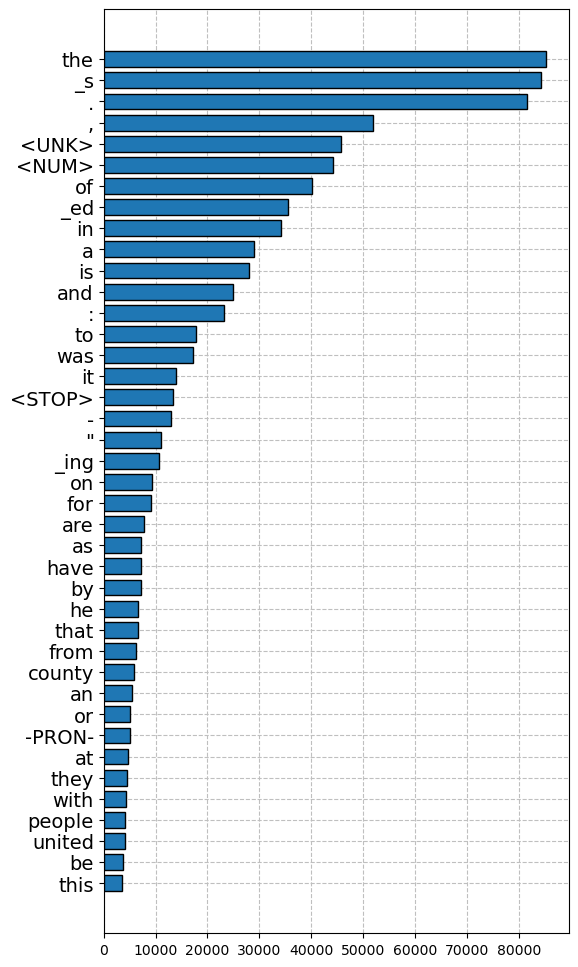

In [6]:
fig_most_common, ax_top50_most_common = plt.subplots()
ax_top50_most_common.barh(y = most_common_words,
                          width = most_common_occurrences, 
                          height = 0.75, 
                          color = "C0", 
                          edgecolor = "black", 
                          zorder = 100)

ax_top50_most_common.grid(linestyle = "dashed", 
                          color = "#bfbfbf", 
                          zorder = -100)

ax_top50_most_common.set_yticks(ticks = ax_top50_most_common.get_yticks())
ax_top50_most_common.set_yticklabels(labels = most_common_words, 
                                     fontsize = 14)

ax_top50_most_common.invert_yaxis()
## If you want log-scale 
# ax_top50_most_common.set_xscale('log')

fig_most_common.set_size_inches([6, 12])

## Trigram Model

### Trigram Input and Output

We want the input `X` and the output `y` to be like this
```
X = [['the', 'word'], ['word', '<_unk>'], ['<_unk>', 'is'], ['is', 'not'], 
     ['not', 'a'], ['a', 'common'], ['common', 'word'], ['word', 'but'], 
     ['but', 'flower'], ['flower', 'is'], ['is', 'a'], ['a', 'common']`]
y = ['<_unk>', 'is', 'not', 'a', 
     'common', 'word', 'but', 'flower', 
     'is', 'a', 'common', 'word']`
```

In this way, we can train the model to predict a word from by looking at its two previous words.
```
['the', 'word']    --> '<_unk>'
['word', '<_unk>'] --> 'is'
['<_unk>', 'is']   --> 'not'
['is', 'not']      --> 'a'
['not', 'a']       --> 'common'
['a', 'common']    --> 'word'
['common', 'word'] --> 'but'
['word', 'but']    --> 'flower'
['but', 'flower']  --> 'is'
['flower', 'is']   --> 'a'
['is', 'a']        --> 'common'
['a', 'common']    --> 'word'
```

Of course, the actual input and output data has to be the tokens of the the words and not the words themselves. Construct the input and output data `X_trigram` and `y_trigram` below.

In [7]:
print(f"token list = {example_sentence_tokenized}")

example_sentence_tokenized_array = np.array(example_sentence_tokenized)

X_trigram = np.vstack([example_sentence_tokenized_array[0:-2],
                       example_sentence_tokenized_array[1:-1]]).T

y_trigram = example_sentence_tokenized_array[2:]

print(f"X_trigram shape = {X_trigram.shape}")
print(f"y_trigram shape = {y_trigram.shape}")

print(f"X_trigram --> y_trigram")
for each_X, each_y in zip(X_trigram, y_trigram):
    print(f"   {each_X}  -->  {each_y}")

token list = [7, 8, 0, 5, 6, 1, 3, 8, 2, 4, 5, 1, 3, 8]
X_trigram shape = (12, 2)
y_trigram shape = (12,)
X_trigram --> y_trigram
   [7 8]  -->  0
   [8 0]  -->  5
   [0 5]  -->  6
   [5 6]  -->  1
   [6 1]  -->  3
   [1 3]  -->  8
   [3 8]  -->  2
   [8 2]  -->  4
   [2 4]  -->  5
   [4 5]  -->  1
   [5 1]  -->  3
   [1 3]  -->  8


### Embedding Look-up

Right now, we have exactly 9 unique words in our example sentence, and they are `['<_unk>', 'a', 'but', 'common', 'flower', 'is', 'not', 'the', 'word']`. Now the goal is to map each unique word to the corresponding vector in the embedding space. In this little practice, let's use a 2-dimensional embedding space and map each word to the very simple looking vectors in the table below. 

| word  |token|   vector   |
|-------|-----|------------|
|<_unk> |  0  | [0.0, 0.0] |
|a      |  1  | [0.1, 0.2] |
|but    |  2  | [0.2, 0.4] |
|common |  3  | [0.3, 0.6] |
|flower |  4  | [0.4, 0.8] |
|is     |  5  | [0.5, 1.0] |
|not    |  6  | [0.6, 1.2] |
|the    |  7  | [0.7, 1.4] |
|word   |  8  | [0.8, 1.6] |

This is what we call an **embedding table** and please remember that what we have here is just a toy example, and the embedding vectors have silly values only for the convenience of illustration. 

In practice:
- The embedding space needs far more dimenions than just two.
- The embedding vectors should reflect some kind of semantic meaning and grammatical role of each word.

Then, you can have a 2D array like `embedding_table` in the cell below to represent the embedding table, so that we can look up each word from the table with a function something like `lookup` in the cell below.

In [8]:
embedding_table = np.array([
    [0.0, 0.0], [0.1, 0.2], [0.2, 0.4], [0.3, 0.6], [0.4, 0.8], 
    [0.5, 1.0], [0.6, 1.2], [0.7, 1.4], [0.8, 1.6]])

def lookup(tokens, embedding_table):
    embedding_vectors = embedding_table[tokens]
    return embedding_vectors

For example, the words `["flower", "is"]`are mapped into their tokens `[4, 5]`. We know from the table that the embedding for `"flower"` is `[0.4, 0.8]` and the embedding for `"is"` is `[0.5, 1.0]`, and that's exactly what the `lookup` function returns. 

In [9]:
tokens = np.array([4, 5])
embedding_vectors = lookup(tokens, embedding_table)
print(f"tokens \n{tokens} \n \nembedding vectors \n{embedding_vectors}")

tokens 
[4 5] 
 
embedding vectors 
[[0.4 0.8]
 [0.5 1. ]]


We can even batch the input tokens. For example, if you want to look up `["flower", "is"]` and `["not", "common"]` at once, we can do that.

In [10]:
tokens_batch = np.array([[4, 5], [6, 3]])
embedding_vectors_batch = lookup(tokens_batch, embedding_table)
print(f"tokens \n{tokens_batch} \n \nembedding vectors \n{embedding_vectors_batch}")

tokens 
[[4 5]
 [6 3]] 
 
embedding vectors 
[[[0.4 0.8]
  [0.5 1. ]]

 [[0.6 1.2]
  [0.3 0.6]]]


A fully connected dense layer expects a batch of flattened vectors, which is not a big problem. We can simply reshape the array.

In [11]:
embedding_vectors_batch.reshape(2, 2*2) #(batch size, words in single input*dimensions for each word)

array([[0.4, 0.8, 0.5, 1. ],
       [0.6, 1.2, 0.3, 0.6]])

In fact, the TensorFlow function `tf.nn.embedding_lookup` is not so different.
- The embedding table should be a **trainable variable**, rather than a simple NumPy Array.
- The embedding table needs better initialization.
    - so that embedding vectors end up with some kind of semantic meaning and grammatical role of each word after the training. 

In [12]:
tf_embedding_table = tf.Variable(tf.random.normal([9, 2], stddev=0.01, dtype=tf.float32))
tf_embedding_vectors = tf.nn.embedding_lookup(tf_embedding_table, X_trigram)
tf_embedding_vectors = tf.reshape(tf_embedding_vectors, (12, 2*2)) 
# (12 input data in a batch, 2 words in a single input x 2 dimensions for each word)

## If the reshaping is confusing to you, 
##     you can un-comment the following block and double-check
# tf_embedding_vector1 = tf.nn.embedding_lookup(tf_embedding_table, X_trigram[:, 0])
# tf_embedding_vector2 = tf.nn.embedding_lookup(tf_embedding_table, X_trigram[:, 1])
# tf_embedding_vectors_check = tf.concat((tf_embedding_vector1, tf_embedding_vector2), axis=1)
# print(tf_embedding_vectors == tf_embedding_vectors_check)

print(tf_embedding_vectors)

tf.Tensor(
[[-6.4650518e-03 -1.3929871e-02 -2.7554804e-03  3.2870506e-03]
 [-2.7554804e-03  3.2870506e-03  4.6966691e-03 -6.7818579e-03]
 [ 4.6966691e-03 -6.7818579e-03 -9.0245018e-03 -7.2137439e-03]
 [-9.0245018e-03 -7.2137439e-03  7.2008595e-05  1.5626976e-02]
 [ 7.2008595e-05  1.5626976e-02  1.0462235e-02  1.1163998e-03]
 [ 1.0462235e-02  1.1163998e-03 -2.9134760e-03  2.6692087e-03]
 [-2.9134760e-03  2.6692087e-03 -2.7554804e-03  3.2870506e-03]
 [-2.7554804e-03  3.2870506e-03 -7.4620545e-03 -1.4975233e-02]
 [-7.4620545e-03 -1.4975233e-02  4.6349391e-03  1.9336650e-02]
 [ 4.6349391e-03  1.9336650e-02 -9.0245018e-03 -7.2137439e-03]
 [-9.0245018e-03 -7.2137439e-03  1.0462235e-02  1.1163998e-03]
 [ 1.0462235e-02  1.1163998e-03 -2.9134760e-03  2.6692087e-03]], shape=(12, 4), dtype=float32)


On the topic, you are also free to use the layered version, [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). Feel free to use it if it helps simplify your implementation. 

### Train and Test Trigram

Now you should be ready to complete every function in the file `trigram.py`. Go finish `trigram.py` and come back when you're ready!

Steps to take: 
- Load the data with `get_data`
- Reshape the input and output data into the Trigram shape
- Initialize the model, train it, and calculate the perplexity

In [13]:
%%time

import trigram 

## Load the data (from trigram.py)
train_id, test_id, vocab = preprocess.get_data(f"{data_path}/train.txt", f"{data_path}/test.txt")

## Process the data
def process_trigram_data(data):
    X = np.array(data[:-1])
    Y = np.array(data[2:])
    X = np.column_stack((X[:-1], X[1:]))
    return X, Y

X0, Y0 = process_trigram_data(train_id)
X1, Y1 = process_trigram_data(test_id)

## Feel free to paste your implementation in here if you want.
trigram_args = trigram.get_text_model(vocab)

trigram_args.model.fit(
    X0, Y0,
    epochs=trigram_args.epochs, 
    batch_size=trigram_args.batch_size,
    validation_data=(X1, Y1)
)

14657/14657 [==============================] - 162s 11ms/step - loss: 4.5499 - perplexityFunction: 120.7652 - val_loss: 4.2733 - val_perplexityFunction: 83.8954
CPU times: total: 12min 33s
Wall time: 2min 44s


### Generate Sentences with Trigram

Try the model with your own pairs of starting words. 

In [14]:
starting_words = [("computer", "is"), ("i", "am"), ("something", "new"), ("this", "is")]

for first, second in starting_words:
    trigram_args.model.generate_sentence(first, second, 45, vocab)

computer is a county in the u . s . state of the <NUM> census , the <UNK> _s . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the
i am " . <STOP> <UNK> : the <UNK> _s . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of
something new jersey . it is the <UNK> _s . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK>
this is the <UNK> _s . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat of <UNK> . the county seat


See anything interesting? 

## RNN Model

### RNN Input and Output

To train an RNN model, the input and output needs to be shaped differently than the trigram model. For an RNN model, the words need to be divided into non-overlapping windows of a fixed size. 
- **Window size** means the number of words each window contains.
- **Non-overlapping** means that a window and the next window do not share a word

Let's do a toy example again with our example sentence
 - `['the', 'word', '<_unk>', 'is', 'not', 'a', 'common', 'word', 'but', 'flower', 'is', 'a', 'common', 'word']`

With our example sentence, one possible arangement of the windows for the input `X` and the output `y` can be the following. 

```
X = [['the', 'word', '<_unk>', 'is'],
     ['not', 'a', 'common', 'word'],
     ['but', 'flower', 'is', 'a']]
     
y = [['word', '<_unk>', 'is', 'not'],
     ['a', 'common', 'word', 'but'],
     ['flower', 'is', 'a', 'common']]
```

In this example, 
+ We have divided the example sentence into non-overlapping windows of size 4. 

- Notice that there is no overlapping word between two consecutives windows.
   - For example `['the', 'word', '<_unk>', 'is']` and `['not', 'a', 'common', 'word']`. 
   
+ The last word in the example sentence `"word"` ended up not being included in the input and output data. 
  + That happened because 13 divided by 4 has one remainder.
    + 13 is the length of the example sentence **minus one**.
    + 4 is the window size.
  + **Why minus one** and not the length of the example sentence itself? 
    + **The output windows in `y` have to be exactly one word behind of their corresponding input windows in `X`.**
    
|Index| Input `X`                        | Output `y`                       |
|-----|----------------------------------|----------------------------------|
|  0  |\['the', 'word', '<_unk>', 'is'\] | \['word', '<_unk>', 'is', 'not'\]|
|  1  |\['not', 'a', 'common', 'word'\]  | \['a', 'common', 'word', 'but'\] |
|  2  |\['but', 'flower', 'is', 'a'\]    | \['flower', 'is', 'a', 'common'\]|



In [15]:
print(f"token list = {example_sentence_tokenized}")
window_size = 4

# 1. Do some NumPy manipulation on the example sentence 
example_sentence_tokenized_array = np.array(example_sentence_tokenized)
remainder = (len(example_sentence_tokenized_array) - 1)%window_size
example_sentence_tokenized_array = example_sentence_tokenized_array[:-remainder]

# 2. Define X_RNN and y_RNN  
X_RNN = example_sentence_tokenized_array[:-1].reshape(-1, 4)
y_RNN = example_sentence_tokenized_array[1:].reshape(-1, 4)

print(f"X_RNN shape = {X_RNN.shape}")
print(f"y_RNN shape = {y_RNN.shape}")

print(f"X_RNN     --> y_RNN")
for each_X, each_y in zip(X_RNN, y_RNN):
    print(f"{each_X} --> {each_y}")

token list = [7, 8, 0, 5, 6, 1, 3, 8, 2, 4, 5, 1, 3, 8]
X_RNN shape = (3, 4)
y_RNN shape = (3, 4)
X_RNN     --> y_RNN
[7 8 0 5] --> [8 0 5 6]
[6 1 3 8] --> [1 3 8 2]
[2 4 5 1] --> [4 5 1 3]


The result should look like this
```
token list = [7, 8, 0, 5, 6, 1, 3, 8, 2, 4, 5, 1, 3, 8]
X_RNN shape = (3, 4)
y_RNN shape = (3, 4)
X_RNN     --> y_RNN
[7 8 0 5] --> [8 0 5 6]
[6 1 3 8] --> [1 3 8 2]
[2 4 5 1] --> [4 5 1 3]
```

PS. Have you noticed that we could have dropped the first word in the example sentence instead of the last word?
- That's only because we did not offset the example sentence and wanted to keep as many words in the input and output
- In practice we draw a **random integer between 0 and the (window size-1)** for every epoch
- Then we remove the random integer number of words from the beginning of the training corpus (= offset)
- Depending on the value of the random integer,
  - Different words end up not being included in `X` and `y` from one epoch to another
  - `X` and `y` end up having different number of windows from one epoch to another
  - For every epoch, the model is trained with similar but slightly different sets of windows 

### Keras LSTM Layer 

Let's take a close look at `tf.keras.layers.LSTM`'s API. First, the Keras LSTM Layer expects the input shape to be in the **batch-major form**, which means the dimensions of the input tensor should be in the order of `[batch, timesteps, embedding]`. 

- In our language model, `timesteps` is basically our `window`. 
  - That's because we treat a sequence of words as a time-series data.
- It also has a keyword argument to enable the input in the **time-major form** `[timesteps, batch, embedding]`, 
  - but we can ignore that now, 
  - since all our data is already in the batch-major form anyways.

In [16]:
embedding_size = 2
embedding_layer = tf.keras.layers.Embedding(input_dim=9, output_dim=embedding_size)
X_RNN_embedding = embedding_layer(X_RNN)

RNN_input_dim_order = ["Batch", "Window", "Embedding"]
print(f"RNN input tokens shape = {X_RNN.shape}")
print(f"RNN embeddings shape   = {X_RNN_embedding.shape}")
for each_dim_meaning, each_dim in zip(RNN_input_dim_order, X_RNN_embedding.shape):
    print(f"{each_dim_meaning:>9s} Size = {each_dim}")

RNN input tokens shape = (3, 4)
RNN embeddings shape   = (3, 4, 2)
    Batch Size = 3
   Window Size = 4
Embedding Size = 2


Perhaps the most important keywards arguments are `units`, `return_state` and `return_sequences`. 
- `units`: the output embedding size
  - It does not necessarily have to be the same as the input embedding size,
  - but we will keep them same in this homework assignment. 
- `return_state`: the layer returns the last state for every window in the batch.
- `return_sequences`: the layer returns the whole output sequence instead of the last output.

Also please note that all Keras LSTM layers have the same weight structures, no matter the value of the Boolean flags.
+ So, we can copy and paste the weights with the `.get_weights()` and `.set_weights()` methods.
+ The input shapes are needed to initialize the weights.

In [17]:
batch_size, window_size, embedding_size= X_RNN_embedding.shape ## (3, 4, 2)
units = embedding_size

lstm           = tf.keras.layers.LSTM(units=embedding_size, return_sequences=False, return_state=False)
lstm_state     = tf.keras.layers.LSTM(units=embedding_size, return_sequences=False, return_state=True )
lstm_seq       = tf.keras.layers.LSTM(units=embedding_size, return_sequences=True,  return_state=False)
lstm_seq_state = tf.keras.layers.LSTM(units=embedding_size, return_sequences=True,  return_state=True )

lstm.build(X_RNN_embedding.shape)
lstm_state.build(X_RNN_embedding.shape)
lstm_seq.build(X_RNN_embedding.shape)
lstm_seq_state.build(X_RNN_embedding.shape)

lstm_weights = lstm.get_weights()
lstm_state.set_weights(lstm_weights)
lstm_seq.set_weights(lstm_weights)
lstm_seq_state.set_weights(lstm_weights)

#### LSTM default

The default output shape is `[batch, embedding]`.

In [18]:
output = lstm(X_RNN_embedding, initial_state = None)
print(f"default output, shape = {output.shape} \n{output.numpy()}")

default output, shape = (3, 2) 
[[ 0.00161557  0.00235702]
 [-0.00074528  0.01052073]
 [ 0.00339125  0.00451707]]


#### LSTM state

When `return_state` is `True`, it returns the last hidden state and the last cell state. 
- The output shape is still `[batch, embedding]`.
- Notice that the last hidden state is the same as the output. 
- The hidden and cell states are in the shape `[batch, embedding]`

In [19]:
output, state_h, state_c = lstm_state(X_RNN_embedding, initial_state = None)

print(f"output, shape = {output.shape} \n{output}\n")
print(f"state_h, shape = {state_h.shape} \n{state_h}\n")
print(f"state_c, shape = {state_c.shape} \n{state_c}")

output, shape = (3, 2) 
[[ 0.00161557  0.00235702]
 [-0.00074528  0.01052073]
 [ 0.00339125  0.00451707]]

state_h, shape = (3, 2) 
[[ 0.00161557  0.00235702]
 [-0.00074528  0.01052073]
 [ 0.00339125  0.00451707]]

state_c, shape = (3, 2) 
[[ 0.00328985  0.00471129]
 [-0.0014698   0.0211465 ]
 [ 0.0067203   0.00902084]]


#### LSTM sequences

When `return_sequences` is `True`, it returns whole sequence of outputs. 
- The output sequence shape is `[batch, timesteps, embedding]`.

In [20]:
output_seq = lstm_seq(X_RNN_embedding, initial_state = None)
print(f"output sequences, shape = {output_seq.shape} \n{output_seq}")

output sequences, shape = (3, 4, 2) 
[[[-2.4522892e-03  1.5255731e-03]
  [-4.0723123e-03  5.4251342e-03]
  [-7.7775243e-04  1.0432137e-02]
  [ 1.6155723e-03  2.3570245e-03]]

 [[-5.1081809e-04 -6.2984526e-03]
  [-9.3808834e-05  3.2802008e-03]
  [ 1.0175529e-03  9.7472044e-03]
  [-7.4528233e-04  1.0520730e-02]]

 [[ 2.3394650e-04  5.9427614e-03]
  [ 2.6258435e-03  3.0164246e-03]
  [ 3.6467051e-03 -3.4381612e-03]
  [ 3.3912468e-03  4.5170700e-03]]]


#### LSTM state and sequences

When `return_states` and `return_sequences` are both `True`, it returns the last states and the whole sequence of outputs. 
- The output sequence shape is `[batch, timesteps, embedding]`.
- **It does not return the sequences of states**. 
  - Unfortunately, there is no argument like `return_sequences_of_states`.
  - When you think about it, the sequence of whole outputs are actually the sequence of whole hidden states,
  - but we still do not know the sequence of whole cell states.  
- It still returns the last states for every window in the batch.
- The hidden and cell states are still in the shape `[batch, embedding]`.


In [21]:
output_seq, state_h, state_c = lstm_seq_state(X_RNN_embedding, initial_state = None)

print(f"output sequences, shape = {output_seq.shape} \n{output_seq}\n")
print(f"state_h, shape = {state_h.shape} \n{state_h}\n")
print(f"state_c, shape = {state_c.shape} \n{state_c}")

output sequences, shape = (3, 4, 2) 
[[[-2.4522892e-03  1.5255731e-03]
  [-4.0723123e-03  5.4251342e-03]
  [-7.7775243e-04  1.0432137e-02]
  [ 1.6155723e-03  2.3570245e-03]]

 [[-5.1081809e-04 -6.2984526e-03]
  [-9.3808834e-05  3.2802008e-03]
  [ 1.0175529e-03  9.7472044e-03]
  [-7.4528233e-04  1.0520730e-02]]

 [[ 2.3394650e-04  5.9427614e-03]
  [ 2.6258435e-03  3.0164246e-03]
  [ 3.6467051e-03 -3.4381612e-03]
  [ 3.3912468e-03  4.5170700e-03]]]

state_h, shape = (3, 2) 
[[ 0.00161557  0.00235702]
 [-0.00074528  0.01052073]
 [ 0.00339125  0.00451707]]

state_c, shape = (3, 2) 
[[ 0.00328985  0.00471129]
 [-0.0014698   0.0211465 ]
 [ 0.0067203   0.00902084]]


### Keras GRU Layer

We can also take a look at `tf.keras.layers.GRU`. It is very similar to the LSTM layer.

In [22]:
gru           = tf.keras.layers.GRU(units=embedding_size, return_sequences=False, return_state=False)
gru_state     = tf.keras.layers.GRU(units=embedding_size, return_sequences=False, return_state=True )
gru_seq       = tf.keras.layers.GRU(units=embedding_size, return_sequences=True,  return_state=False)
gru_seq_state = tf.keras.layers.GRU(units=embedding_size, return_sequences=True,  return_state=True )

# the Keras GRU layers initialize their weight 
#   not when they are declared
#   but when they are complied
gru.build(X_RNN_embedding.shape)
gru_state.build(X_RNN_embedding.shape)
gru_seq.build(X_RNN_embedding.shape)
gru_seq_state.build(X_RNN_embedding.shape)

# Now all four layers have exact same weights
gru_weights = gru.get_weights()
gru_state.set_weights(gru_weights)
gru_seq.set_weights(gru_weights)
gru_seq_state.set_weights(gru_weights)

#### GRU default

The default output shape is `[batch, embedding]`.

In [23]:
output = gru(X_RNN_embedding, initial_state = None)
print(f"default output, shape = {output.shape} \n{output.numpy()}")

default output, shape = (3, 2) 
[[-0.00091759 -0.00061628]
 [ 0.01294315  0.00215647]
 [ 0.01562922 -0.00285151]]


#### GRU state

When `return_state` is `True`, it returns the last hidden state and the last cell state. 
- The output shape is still `[batch, embedding]`.
- Notice that the last hidden state is the same as the output. 
- The hidden and cell states are in the shape `[batch, embedding]`

In [24]:
output, state_gru = gru_state(X_RNN_embedding, initial_state = None)

print(f"output, shape = {output.shape} \n{output}\n")
print(f"state_gru, shape = {state_gru.shape} \n{state_gru}\n")

output, shape = (3, 2) 
[[-0.00091759 -0.00061628]
 [ 0.01294315  0.00215647]
 [ 0.01562922 -0.00285151]]

state_gru, shape = (3, 2) 
[[-0.00091759 -0.00061628]
 [ 0.01294315  0.00215647]
 [ 0.01562922 -0.00285151]]



#### GRU sequences

When `return_sequences` is `True`, it returns whole sequence of outputs. 
- The output sequence shape is `[batch, timesteps, embedding]`.

In [25]:
output_seq = gru_seq(X_RNN_embedding, initial_state = None)
print(f"output sequences, shape = {output_seq.shape} \n{output_seq}")

output sequences, shape = (3, 4, 2) 
[[[-0.00174282  0.002596  ]
  [ 0.00316368  0.00370143]
  [ 0.01772979 -0.00019606]
  [-0.00091759 -0.00061628]]

 [[-0.01526868  0.00101969]
  [ 0.01118421 -0.00148892]
  [ 0.02243467 -0.00182809]
  [ 0.01294315  0.00215647]]

 [[ 0.01332255 -0.00068226]
  [ 0.0074104  -0.00199612]
  [-0.00510886 -0.00207974]
  [ 0.01562922 -0.00285151]]]


#### GRU state and sequences

When `return_states` and `return_sequences` are both `True`, it returns the last states and the whole sequence of outputs. 
- The output sequence shape is `[batch, timesteps, embedding]`.
- It does not return the sequences of states again. 
  - **However**, the sequence of whole outputs are actually the sequence of whole hidden states,
- It still returns the last states for every window in the batch.
- The hidden and cell states are still in the shape `[batch, embedding]`.


In [26]:
output_seq, state_gru = gru_seq_state(X_RNN_embedding, initial_state = None)

print(f"output sequences, shape = {output_seq.shape} \n{output_seq}\n")
print(f"state_gru, shape = {state_gru.shape} \n{state_gru}\n")

output sequences, shape = (3, 4, 2) 
[[[-0.00174282  0.002596  ]
  [ 0.00316368  0.00370143]
  [ 0.01772979 -0.00019606]
  [-0.00091759 -0.00061628]]

 [[-0.01526868  0.00101969]
  [ 0.01118421 -0.00148892]
  [ 0.02243467 -0.00182809]
  [ 0.01294315  0.00215647]]

 [[ 0.01332255 -0.00068226]
  [ 0.0074104  -0.00199612]
  [-0.00510886 -0.00207974]
  [ 0.01562922 -0.00285151]]]

state_gru, shape = (3, 2) 
[[-0.00091759 -0.00061628]
 [ 0.01294315  0.00215647]
 [ 0.01562922 -0.00285151]]



### Train and Test with RNN

Now you should be ready to complete every function in the file `trigram.py`. Go finish `trigram.py` and come back to here.

Steps to take: 
- Load the data with `get_data`
- Reshape the input and output data into the RNN shape
- Initialize the model, train it, and calculate the perplexity

In [27]:
%%time

import rnn

train_id, test_id, vocab = preprocess.get_data("../data/train.txt", "../data/test.txt")

train_id = np.array(train_id)
test_id  = np.array(test_id)
X0, Y0 = train_id[:-1], train_id[1:]
X1, Y1  = test_id[:-1],  test_id[1:]


X0 = X0[:-(len(X0) % 20)]
Y0 = Y0[:-(len(Y0) % 20)]
X1 = X1[:-(len(X1) % 20)]
Y1 = Y1[:-(len(Y1) % 20)]

np.reshape(X0, (-1, 20))
np.reshape(X1, (-1, 20))
np.reshape(Y0, (-1, 20))
np.reshape(Y1, (-1, 20))

rnn_args = rnn.get_text_model(vocab)

rnn_args.model.fit(
    X0, Y0,
    epochs=rnn_args.epochs, 
    batch_size=rnn_args.batch_size,
    validation_data=(X1, Y1)
)

7328/7328 [==============================] - 264s 36ms/step - loss: 4.6824 - perplexityFunction: 130.1775 - val_loss: 4.5129 - val_perplexityFunction: 97.1454
CPU times: total: 21min 55s
Wall time: 4min 25s


### Generate Sentences with RNN

Try the model with your own pairs of starting words. 

In [44]:
## Feel free to mess around with the word list to see the model try to generate sentences
for word1 in ''.split():
    if word1 not in vocab: print(f"{word1} not in vocabulary")            
    else: rnn_args.model.generate_sentence(word1, 20, vocab, 10)

ooh not in vocabulary
wee not in vocabulary
ooh not in vocabulary
I not in vocabulary
look on the second single - known to make me " . it became mayor in which make them in this
just a city and was <UNK> in <UNK> . <STOP> the <UNK> of -PRON- , he is <UNK> in -PRON- fox
like <UNK> _ed as one , and the name to have the <NUM> and it also have won the <NUM> and
buddy not in vocabulary
holly not in vocabulary
